In [1]:
import numpy as np
import pyscf
from pyscf import qmmm,scf,dft,gto
import matplotlib.pyplot as plt
import basis_set_exchange as bse
angstrom = 1 / 0.52917721067
import ipyvolume as ipv
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import cm

In [2]:
COd=gto.Mole(atom='C 0 0 0 ; O 3.1 0 0 ',unit='bohrs',basis='def2-QZVPP')
COs=gto.Mole(atom='C 0 0 0 ; O 3.1 0 0 ',unit='bohrs',basis='sto-3G')
scf.UHF(COd).run()
scf.UHF(COs).run()

Initialize <pyscf.gto.mole.Mole object at 0x7fa212a45978> in <pyscf.scf.uhf.UHF object at 0x7fa212a459b0>


converged SCF energy = -112.511517840359  <S^2> = 2.533973e-11  2S+1 = 1


Initialize <pyscf.gto.mole.Mole object at 0x7fa212a45940> in <pyscf.scf.uhf.UHF object at 0x7fa212a459e8>


converged SCF energy = -110.947506927565  <S^2> = 2.1989521e-11  2S+1 = 1


In [19]:
def dm_ccsd(mol,ao):
    calc=scf.UHF(mol)
    includeonly = [0, 1]
    deltaZ=np.array((0.05,-0.05),dtype=float)*ao
    mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords(), deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)
    mf = NoSelfQMMM()
    hfe=mf.kernel()
    mycc = pyscf.cc.CCSD(mf).set(frozen = 2,max_cycle=100).run()
    cc_en=mycc.energy
    dm1 = mycc.make_rdm1()
    dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff[0],dm1[0], mf.mo_coeff[0].conj())
    dm1_ao += np.einsum('pi,ij,qj->pq', mf.mo_coeff[1],dm1[1], mf.mo_coeff[1].conj())
    return dm1_ao,mycc

In [20]:
sto_deriv=dm_ccsd(COs,1)
sto_deriv

converged SCF energy = -110.573354799163  <S^2> = 1.2177235e-08  2S+1 = 1
E(UCCSD) = -110.8031112344436  E_corr = -0.2297564352809185


(array([[ 2.12571172e+00, -5.09088587e-01,  7.95114515e-02,
          3.80394549e-18, -4.12992859e-18, -5.10143700e-03,
          4.49081654e-02,  2.32524407e-02,  4.05993753e-18,
         -1.80499018e-16],
        [-5.09088587e-01,  2.06952340e+00, -3.32238062e-01,
         -3.44983436e-17,  1.08279378e-16,  3.41459890e-02,
         -2.39856607e-01, -1.09261817e-02, -1.35254609e-17,
          8.17107469e-16],
        [ 7.95114515e-02, -3.32238062e-01,  7.00607213e-01,
         -9.82854808e-19,  3.10188870e-15, -1.72101706e-02,
         -1.15369910e-02, -7.06542967e-01,  7.29440659e-17,
         -1.67300190e-15],
        [ 3.80394549e-18, -3.44983436e-17, -9.82854808e-19,
          6.07712634e-01, -2.46330734e-15, -8.79050598e-17,
          4.66437958e-16,  5.76550642e-17,  7.69949746e-01,
         -1.56992475e-16],
        [-4.12992859e-18,  1.08279378e-16,  3.10188870e-15,
         -2.45289900e-15,  6.07712634e-01,  3.45354910e-16,
         -1.28700264e-15, -1.06871289e-16,  3.851086

In [5]:
#def2_deriv=(dm_ccsd(COd,1)-dm_ccsd(COd,-1))/2

In [6]:
#%store sto_deriv
#%store def2_deriv
%store -r sto_deriv
%store -r def2_deriv
def2_deriv

array([[ 5.18629307e-01, -7.89484074e-02,  1.40499483e-01, ...,
        -5.85435269e-05,  4.51964579e-17,  7.74458065e-05],
       [-7.89484074e-02, -3.06252298e-04, -5.45372675e-02, ...,
        -2.14582657e-06,  1.84944130e-18,  2.83866173e-06],
       [ 1.40499483e-01, -5.45372675e-02, -4.94015449e-02, ...,
        -5.09397620e-05,  3.77666297e-17,  6.73869710e-05],
       ...,
       [-5.85435269e-05, -2.14582657e-06, -5.09397620e-05, ...,
        -2.59948211e-05,  1.60939993e-17, -2.42599037e-06],
       [ 4.51964579e-17,  1.84944130e-18,  3.77666297e-17, ...,
         1.60939993e-17, -2.45658438e-05,  1.73686137e-17],
       [ 7.74458065e-05,  2.83866173e-06,  6.73869710e-05, ...,
        -2.42599037e-06,  1.73686137e-17, -2.14431117e-05]])

In [7]:
xv=np.linspace(-2,5.,232)
yv=np.linspace(-3,3,232)
zv=np.array(0.,dtype=float)
xm,ym,zm=np.meshgrid(xv,yv,zv)

In [8]:
gridcoords=np.vstack((xm.flatten(),ym.flatten(),zm.flatten())).T

In [9]:
mol=COs
ao_value = pyscf.dft.numint.eval_ao(mol, gridcoords, deriv=0)
Drho_sto = dft.numint.eval_rho(mol, ao_value, sto_deriv, xctype='LDA')
mol=COd
ao_value = pyscf.dft.numint.eval_ao(mol, gridcoords, deriv=0)
Drho_def = dft.numint.eval_rho(mol, ao_value, def2_deriv, xctype='LDA')

In [10]:
#mol.search_ao_label('d')
[x.split(' ')[2] for x in COs.ao_labels()]
COd.ao_labels()

['0 C 1s    ',
 '0 C 2s    ',
 '0 C 3s    ',
 '0 C 4s    ',
 '0 C 5s    ',
 '0 C 6s    ',
 '0 C 7s    ',
 '0 C 2px   ',
 '0 C 2py   ',
 '0 C 2pz   ',
 '0 C 3px   ',
 '0 C 3py   ',
 '0 C 3pz   ',
 '0 C 4px   ',
 '0 C 4py   ',
 '0 C 4pz   ',
 '0 C 5px   ',
 '0 C 5py   ',
 '0 C 5pz   ',
 '0 C 3dxy  ',
 '0 C 3dyz  ',
 '0 C 3dz^2 ',
 '0 C 3dxz  ',
 '0 C 3dx2-y2',
 '0 C 4dxy  ',
 '0 C 4dyz  ',
 '0 C 4dz^2 ',
 '0 C 4dxz  ',
 '0 C 4dx2-y2',
 '0 C 5dxy  ',
 '0 C 5dyz  ',
 '0 C 5dz^2 ',
 '0 C 5dxz  ',
 '0 C 5dx2-y2',
 '0 C 4fy^3 ',
 '0 C 4fxyz ',
 '0 C 4fyz^2',
 '0 C 4fz^3 ',
 '0 C 4fxz^2',
 '0 C 4fzx^2',
 '0 C 4fx^3 ',
 '0 C 5fy^3 ',
 '0 C 5fxyz ',
 '0 C 5fyz^2',
 '0 C 5fz^3 ',
 '0 C 5fxz^2',
 '0 C 5fzx^2',
 '0 C 5fx^3 ',
 '0 C 5g-4  ',
 '0 C 5g-3  ',
 '0 C 5g-2  ',
 '0 C 5g-1  ',
 '0 C 5g 0  ',
 '0 C 5g 1  ',
 '0 C 5g 2  ',
 '0 C 5g 3  ',
 '0 C 5g 4  ',
 '1 O 1s    ',
 '1 O 2s    ',
 '1 O 3s    ',
 '1 O 4s    ',
 '1 O 5s    ',
 '1 O 6s    ',
 '1 O 7s    ',
 '1 O 2px   ',
 '1 O 2py   ',
 '1 O 2

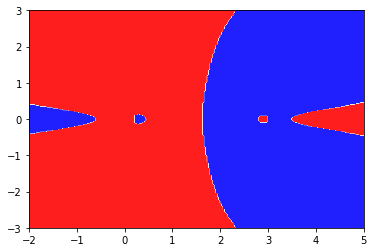

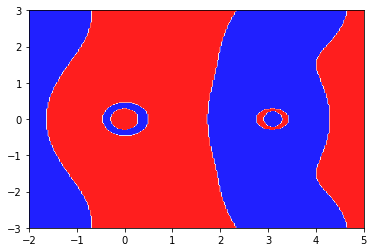

In [11]:
rho_2dsto=np.array([Drho_sto[x::232] for x in range(232)]).T
plt.contourf(xv,yv,rho_2dsto/abs(rho_2dsto),cmap=cm.get_cmap('bwr'))
plt.show()
rho_2ddef=np.array([Drho_def[x::232] for x in range(232)]).T
plt.contourf(xv,yv,rho_2ddef/abs(rho_2ddef),cmap=cm.get_cmap('bwr'))
plt.show()

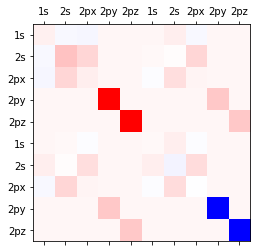

In [12]:
yt=[x.split(' ')[2] for x in COs.ao_labels()]
fig, axes = plt.subplots()
axes.matshow(sto_deriv,cmap=cm.get_cmap('bwr'))
start, end = axes.get_ylim()  # don't know why changing ticks modifies plot dimensions
axes.yaxis.set_ticks([0,1,2,3,4,5,6,7,8,9],minor=False)
axes.set_yticklabels(yt,minor=False)
axes.xaxis.set_ticks([0,1,2,3,4,5,6,7,8,9],minor=False)
axes.set_xticklabels(yt,minor=False)
axes.set_ylim(start, end) 
plt.show()

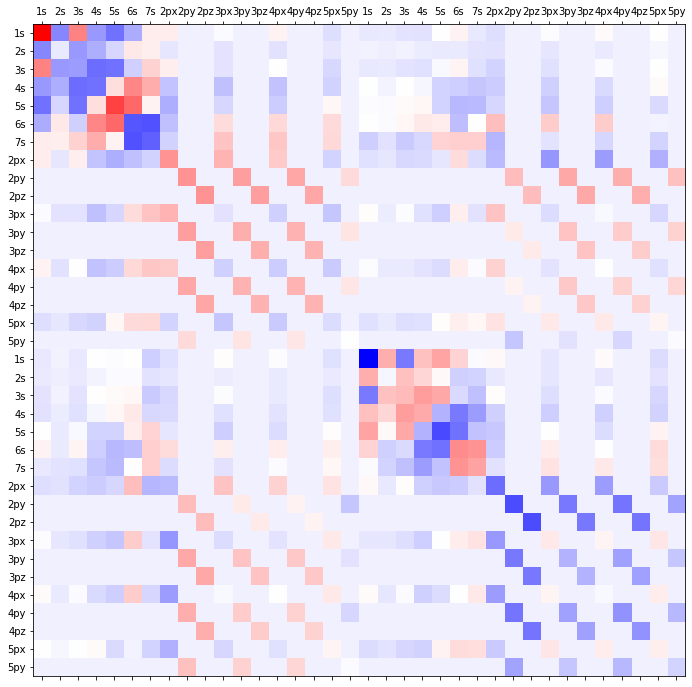

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
['0 C 1s    ', '0 C 2s    ', '0 C 3s    ', '0 C 4s    ', '0 C 5s    ', '0 C 6s    ', '0 C 7s    ', '0 C 2px   ', '0 C 2py   ', '0 C 2pz   ', '0 C 3px   ', '0 C 3py   ', '0 C 3pz   ', '0 C 4px   ', '0 C 4py   ', '0 C 4pz   ', '0 C 5px   ', '0 C 5py   ', '1 O 1s    ', '1 O 2s    ', '1 O 3s    ', '1 O 4s    ', '1 O 5s    ', '1 O 6s    ', '1 O 7s    ', '1 O 2px   ', '1 O 2py   ', '1 O 2pz   ', '1 O 3px   ', '1 O 3py   ', '1 O 3pz   ', '1 O 4px   ', '1 O 4py   ', '1 O 4pz   ', '1 O 5px   ', '1 O 5py   ']


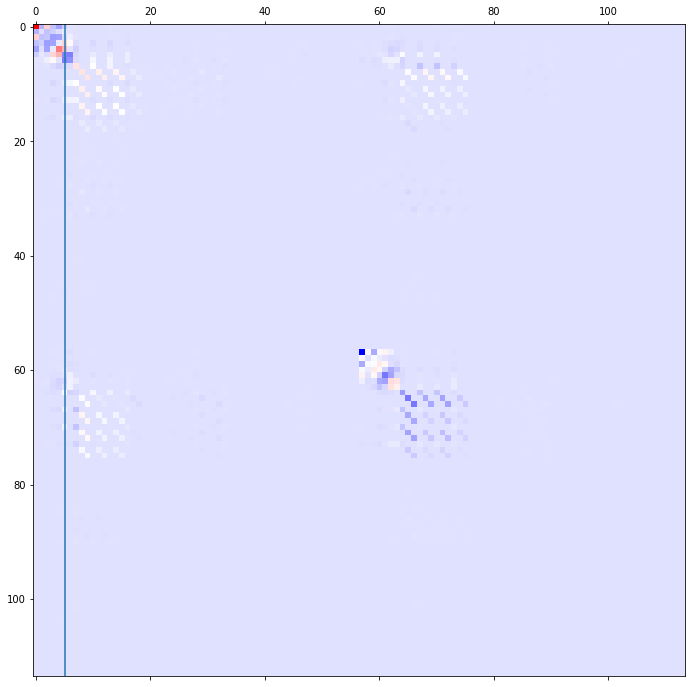

In [14]:
fig, axes = plt.subplots(figsize=(12,12))
a=[x for x in range(18)]
a.extend(x for x in range(57,75))
a=np.asarray(a,dtype=int)
yt=[(COd.ao_labels()[x]).split(' ')[2]  for x in a]
axes.matshow(abs(def2_deriv[np.ix_(a,a)])**0.5*(def2_deriv[np.ix_(a,a)]/abs(def2_deriv[np.ix_(a,a)])),cmap=cm.get_cmap('bwr'))
start, end = axes.get_ylim()  # don't know why changing ticks modifies plot dimensions
axes.yaxis.set_ticks([x for x in range(a.shape[0])],minor=False)
axes.set_yticklabels(yt,minor=False)
axes.xaxis.set_ticks([x for x in range(a.shape[0])],minor=False)
axes.set_xticklabels(yt,minor=False)
axes.set_ylim(start, end) 
plt.show()
print(list(a))
print([COd.ao_labels()[x] for x in a])
fig, axes2 = plt.subplots(figsize=(12,12))
axes2.matshow(def2_deriv,cmap=cm.get_cmap('bwr'))
axes2.axvline(5)
plt.show()

In [15]:
[0.0, 0.775, 1., 0.225]
[0.0, 0.55, 1., 0.225]
[0.0, 0.375, 0.25, 0.125]
[0.25, 0.0, 0.75, 0.375]

[0.25, 0.0, 0.75, 0.375]

In [65]:
225*2*7/6


525.0

## Figures

[-8.54954452e+01 -2.83310786e-02 -2.63682372e-03 -6.39995247e-04
 -7.56954417e-05  6.55406992e-04  2.52369438e-03  8.56813378e-03
  4.46692424e-02  5.39300393e+01]


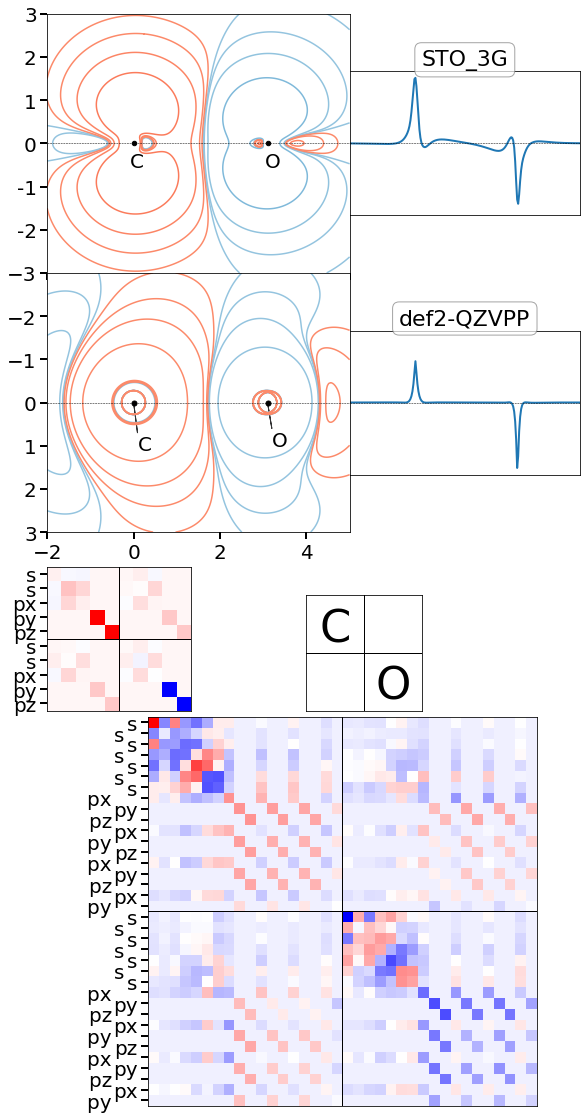

In [124]:
fig = plt.figure(figsize=(8, 16))
###  The dimensions [left, bottom, width, height] of the new axes.
## All quantities are in fractions of figure width and height.
contourSTO= fig.add_axes([0.1, 0.755, .525, 0.225],xticklabels=[])
contourDEF= fig.add_axes([0.1, 0.53, .525, 0.225])
sliceSTO= fig.add_axes([0.625, 0.805, .4, 0.125],yticks=[],xticks=[])
sliceDEF= fig.add_axes([0.625, 0.58, .4, 0.125],xticks=[],yticks=[])

dmSTO = fig.add_axes([0.1, 0.375, 0.250, 0.125],xticklabels=[],yticklabels=[])
dmEX= fig.add_axes([0.55, 0.375, 0.2, 0.1],xticks=[],yticks=[])
dmDEF = fig.add_axes([0.275, 0.032, 0.675, 0.3375],xticklabels=[],yticklabels=[])

        # sto cp
levels = np.percentile(rho_2dsto.flatten(), np.linspace(0, 100, 10))
colors = []
for level in levels:
    if level < 0:
        cmap = cm.get_cmap('Blues')
        extreme = levels[0]
    else:
        cmap = cm.get_cmap('Reds')
        extreme = levels[-1]
    scaled = level / extreme
    scaled = scaled * .6 + 0.4
    colors.append(cmap(scaled))
    
contourSTO.contour(xv,yv,rho_2dsto, levels = levels, colors = colors)
contourSTO.set_ylim(3, -3)
contourSTO.set_yticklabels([3,2,1,0,-1,-2],fontsize=20)

contourSTO.scatter([0.,3.1],[0.,0.],color='black',s=20)
contourSTO.text(x=-0.08,y=0.55,s='C',fontsize=20)
contourSTO.text(x=3.03,y=0.55,s='O',fontsize=20)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.7)
#contourSTO.text(4.94,-2.86, "STO-3G", ha="right", va="top", size=22,bbox=bbox_props,alpha=.9)
contourSTO.tick_params(width=2,length=7 )
contourSTO.axhline(0.,linestyle='--',color='black',linewidth=.5)

       ### def cp
levels = np.percentile(rho_2ddef.flatten(), np.linspace(0, 100, 10))
print (levels)
colors = []
for level in levels:
    if level < 0:
        cmap = cm.get_cmap('Blues')
        extreme = levels[0]
    else:
        cmap = cm.get_cmap('Reds')
        extreme = levels[-1]
    scaled = level / extreme
    scaled = scaled * .6 + 0.4
    colors.append(cmap(scaled))
contourDEF.contour(xv,yv,rho_2ddef, levels = levels, colors = colors)
contourDEF.set_ylim(3, -3)
contourDEF.tick_params(labelsize=20)
contourDEF.scatter([0.,3.1],[0.,0.],color='black',s=25)
contourDEF.text(x=0.1,y=1.10,s='C',fontsize=20)
contourDEF.text(x=3.2,y=1.0,s='O',fontsize=20)
#contourDEF.text(4.94,-2.86, "def2-QZVPP", ha="right", va="top", size=22,bbox=bbox_props,alpha=.9)
contourDEF.arrow(0.,0.,0.09,0.7,alpha=.8)
contourDEF.arrow(3.1,0.,0.1,0.6,alpha=.8)
contourDEF.tick_params(width=2,length=7 )
contourDEF.axhline(0.,linestyle='--',color='black',linewidth=.5)

sliceSTO.set_ylim(-max(abs(rho_2dsto[115]))*1.1,max(abs(rho_2dsto[115]))*1.1)
sliceSTO.set_xlim(-2,5)
sliceSTO.plot(np.linspace(-2,5.,232),rho_2dsto[115],linewidth=2.)
sliceSTO.axhline(0.,linestyle='--',color='black',linewidth=.5)
sliceSTO.set_title("STO_3G",fontsize=22,bbox=bbox_props,horizontalalignment="center")
sliceDEF.set_title("def2-QZVPP",fontsize=22,bbox=bbox_props,horizontalalignment="center")

sliceDEF.set_ylim(-max(abs(rho_2ddef[115]))*1.1,max(abs(rho_2ddef[115]))*1.1)
sliceDEF.set_xlim(-2,5)
sliceDEF.plot(np.linspace(-2,5.,232),rho_2ddef[115],linewidth=2.)
sliceDEF.axhline(0.,linestyle='--',color='black',linewidth=.5)

# density matrices
yt=[x.split()[2][1:] for x in COs.ao_labels()]
dmSTO.matshow(sto_deriv,cmap=cm.get_cmap('bwr'))
dmSTO.tick_params()

start, end = dmSTO.get_ylim()  # don't know why changing ticks modifies plot dimensions
dmSTO.yaxis.set_ticks([0,1,2,3,4,5,6,7,8,9],minor=False)
dmSTO.xaxis.set_ticks([],minor=False)
dmSTO.set_yticklabels(yt,minor=False,fontsize=20)
dmSTO.tick_params(width=2,length=7 )
#dmSTO.xaxis.set_ticks([0,1,2,3,4,5,6,7,8,9],minor=False)
#dmSTO.set_xticklabels(yt,minor=False)
dmSTO.set_ylim(start, end)
dmSTO.axhline(4.5,color='black',linewidth=1.)
dmSTO.axvline(4.5,color='black',linewidth=1.)

#def2-QZVPP
a=[x for x in range(18)]
a.extend(x for x in range(57,75))
a=np.asarray(a,dtype=int)
yt=[(COd.ao_labels()[x]).split()[2][1:]  for x in a]
for i in range(len(yt)//2):
    yt[2*i+1]=yt[2*i+1]+'  '*len(yt[2*i+1])
dmDEF.matshow(abs(def2_deriv[np.ix_(a,a)])**0.5*(def2_deriv[np.ix_(a,a)]/abs(def2_deriv[np.ix_(a,a)])),cmap=cm.get_cmap('bwr'))
start, end = axes.get_ylim()  # don't know why changing ticks modifies plot dimensions
dmDEF.yaxis.set_ticks([x for x in range(a.shape[0])],minor=False)
dmDEF.xaxis.set_ticks([],minor=False)
dmDEF.set_yticklabels(yt,minor=False,fontsize=20)
dmDEF.tick_params(width=2,length=7 )
#dmDEF.xaxis.set_ticks([x for x in range(a.shape[0])],minor=False)
#dmDEF.set_xticklabels(yt,minor=False)
dmDEF.set_ylim(start, end)
dmDEF.axhline(17.45,color='black',linewidth=1.)
dmDEF.axvline(17.5,color='black',linewidth=1.)

dmEX.axhline(.5,color='black',linewidth=1.)
dmEX.axvline(.5,color='black',linewidth=1.)
dmEX.text(0.25,0.71,'C',fontsize=45,verticalalignment='center', horizontalalignment="center")
dmEX.text(0.75,0.21,'O',fontsize=45,verticalalignment='center', horizontalalignment="center")


plt.savefig('countour_dm_plot.png')

In [ ]:
fig = plt.figure(figsize=(8, 16))
###  The dimensions [left, bottom, width, height] of the new axes.
## All quantities are in fractions of figure width and height.
contourSTO= fig.add_axes([0.05, 0.755, .525, 0.225],xticklabels=[])
contourDEF= fig.add_axes([0.05, 0.53, .525, 0.225])
sliceSTO= fig.add_axes([0.575, 0.805, .4, 0.125],yticks=[])
sliceDEF= fig.add_axes([0.575, 0.58, .4, 0.125],xticks=[],yticks=[])

dmSTO = fig.add_axes([0.05, 0.375, 0.250, 0.125],xticklabels=[],yticklabels=[])
dmEX= fig.add_axes([0.55, 0.375, 0.2, 0.1],xticks=[],yticks=[])
dmDEF = fig.add_axes([0.275, 0.0, 0.675, 0.3375],xticklabels=[],yticklabels=[])

        # sto cp
levels = np.percentile(rho_2dsto.flatten(), np.linspace(0, 100, 10))
colors = []
for level in levels:
    if level < 0:
        cmap = cm.get_cmap('Blues')
        extreme = levels[0]
    else:
        cmap = cm.get_cmap('Reds')
        extreme = levels[-1]
    scaled = level / extreme
    scaled = scaled * .6 + 0.4
    colors.append(cmap(scaled))
    
contourSTO.contour(xv,yv,rho_2dsto, levels = levels, colors = colors)
contourSTO.set_ylim(3, -3)
contourSTO.set_yticklabels([3,2,1,0,-1,-2],fontsize=20)

contourSTO.scatter([0.,3.1],[0.,0.],color='black',s=20)
contourSTO.text(x=-0.08,y=0.55,s='C',fontsize=20)
contourSTO.text(x=3.03,y=0.55,s='O',fontsize=20)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.7)
contourSTO.text(4.94,-2.86, "STO-3G", ha="right", va="top", size=22,bbox=bbox_props,alpha=.9)
contourSTO.tick_params(width=2,length=7 )
contourSTO.axhline(0.,linestyle='--',color='black',linewidth=.5)

       ### def cp
levels = np.percentile(rho_2ddef.flatten(), np.linspace(0, 100, 10))
print (levels)
colors = []
for level in levels:
    if level < 0:
        cmap = cm.get_cmap('Blues')
        extreme = levels[0]
    else:
        cmap = cm.get_cmap('Reds')
        extreme = levels[-1]
    scaled = level / extreme
    scaled = scaled * .6 + 0.4
    colors.append(cmap(scaled))
contourDEF.contour(xv,yv,rho_2ddef, levels = levels, colors = colors)
contourDEF.set_ylim(3, -3)
contourDEF.tick_params(labelsize=20)
contourDEF.scatter([0.,3.1],[0.,0.],color='black',s=25)
contourDEF.text(x=0.1,y=1.10,s='C',fontsize=20)
contourDEF.text(x=3.2,y=1.0,s='O',fontsize=20)
contourDEF.text(4.94,-2.86, "def2-QZVPP", ha="right", va="top", size=22,bbox=bbox_props,alpha=.9)
contourDEF.arrow(0.,0.,0.09,0.7,alpha=.8)
contourDEF.arrow(3.1,0.,0.1,0.6,alpha=.8)
contourDEF.tick_params(width=2,length=7 )
contourDEF.axhline(0.,linestyle='--',color='black',linewidth=.5)

sliceSTO.set_ylim(-max(abs(rho_2dsto[115]))*1.1,max(abs(rho_2dsto[115]))*1.1)
sliceSTO.set_xlim(-2,5)
sliceSTO.plot(np.linspace(-2,5.,232),rho_2dsto[115],linewidth=2.)
sliceSTO.axhline(0.,linestyle='--',color='black',linewidth=.5)
sliceSTO.set_title("STO_3G",)
sliceDEF.set_ylim(-max(abs(rho_2ddef[115]))*1.1,max(abs(rho_2ddef[115]))*1.1)
sliceDEF.set_xlim(-2,5)
sliceDEF.plot(np.linspace(-2,5.,232),rho_2ddef[115],linewidth=2.)
sliceDEF.axhline(0.,linestyle='--',color='black',linewidth=.5)

# density matrices
yt=[x.split()[2][1:] for x in COs.ao_labels()]
dmSTO.matshow(sto_deriv,cmap=cm.get_cmap('bwr'))
dmSTO.tick_params()

start, end = dmSTO.get_ylim()  # don't know why changing ticks modifies plot dimensions
dmSTO.yaxis.set_ticks([0,1,2,3,4,5,6,7,8,9],minor=False)
dmSTO.xaxis.set_ticks([],minor=False)
dmSTO.set_yticklabels(yt,minor=False,fontsize=20)
dmSTO.tick_params(width=2,length=7 )
#dmSTO.xaxis.set_ticks([0,1,2,3,4,5,6,7,8,9],minor=False)
#dmSTO.set_xticklabels(yt,minor=False)
dmSTO.set_ylim(start, end)
dmSTO.axhline(4.5,color='black',linewidth=1.)
dmSTO.axvline(4.5,color='black',linewidth=1.)

#def2-QZVPP
a=[x for x in range(18)]
a.extend(x for x in range(57,75))
a=np.asarray(a,dtype=int)
yt=[(COd.ao_labels()[x]).split()[2][1:]  for x in a]
for i in range(len(yt)//2):
    yt[2*i+1]=yt[2*i+1]+'  '*len(yt[2*i+1])
dmDEF.matshow(abs(def2_deriv[np.ix_(a,a)])**0.5*(def2_deriv[np.ix_(a,a)]/abs(def2_deriv[np.ix_(a,a)])),cmap=cm.get_cmap('bwr'))
start, end = axes.get_ylim()  # don't know why changing ticks modifies plot dimensions
dmDEF.yaxis.set_ticks([x for x in range(a.shape[0])],minor=False)
dmDEF.xaxis.set_ticks([],minor=False)
dmDEF.set_yticklabels(yt,minor=False,fontsize=20)
dmDEF.tick_params(width=2,length=7 )
#dmDEF.xaxis.set_ticks([x for x in range(a.shape[0])],minor=False)
#dmDEF.set_xticklabels(yt,minor=False)
dmDEF.set_ylim(start, end)
dmDEF.axhline(17.45,color='black',linewidth=1.)
dmDEF.axvline(17.5,color='black',linewidth=1.)

dmEX.axhline(.5,color='black',linewidth=1.)
dmEX.axvline(.5,color='black',linewidth=1.)
dmEX.text(0.25,0.71,'C',fontsize=45,verticalalignment='center', horizontalalignment="center")
dmEX.text(0.75,0.21,'O',fontsize=45,verticalalignment='center', horizontalalignment="center")


plt.savefig('countour_dm_plot_2.png')